<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import time
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

In [6]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [7]:
data.sort_index(inplace=True)

In [24]:
#Функция информации о таблицах
def check(df):

    print('Первые пять строк: \n', df.head())
    print('########################')
    print('Информация о талице: \n', df.info())
    print('########################')
    print('Описание данных: \n', df.describe())
    print('########################')
    display(pd.DataFrame(round((df.isna().mean()*100),2), columns=['NaNs, %']).sort_values(by='NaNs, %', ascending=False).style.format(
    '{:.2f}').background_gradient('coolwarm'))
    print('########################')
    print('Количество дупликатов в таблице: \n', df.reset_index().duplicated().sum())
    print('########################')

In [25]:
check(data)

Первые пять строк: 
                      num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
########################
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
Информация о талице: 
 None
########################
Описание данных: 
          num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000
########################


,"NaNs, %"
num_orders,0.00


########################
Количество дупликатов в таблице: 
 0
########################


In [12]:
df = data.resample('1H').sum()

In [13]:
#Функция создания признаков
def make_features(data, max_lag, rolling_mean_size):
    frame = data.copy()
    frame['month'] = frame.index.month
    frame['day'] = frame.index.day
    frame['dayofweek'] = frame.index.dayofweek
    frame['hour'] = frame.index.hour
    for lag in range(1, max_lag + 1):
        frame['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    frame['rolling_mean'] = frame['num_orders'].shift().rolling(rolling_mean_size).mean()
    return frame
frame = make_features(df, 7, 5)

### Вывод

- В данных нет пропусков, дупликатов
- Был произведен ресемплинг 1 час
- Созданы признаки с месяцем, днем, днем недели, часом, отстающие значения, скользящее среднее 

## Анализ

In [26]:
check(frame)

Первые пять строк: 
                      num_orders  month  day  dayofweek  hour  lag_1  lag_2  \
datetime                                                                     
2018-03-01 00:00:00         124      3    1          3     0    NaN    NaN   
2018-03-01 01:00:00          85      3    1          3     1  124.0    NaN   
2018-03-01 02:00:00          71      3    1          3     2   85.0  124.0   
2018-03-01 03:00:00          66      3    1          3     3   71.0   85.0   
2018-03-01 04:00:00          43      3    1          3     4   66.0   71.0   

                     lag_3  lag_4  lag_5  lag_6  lag_7  rolling_mean  
datetime                                                              
2018-03-01 00:00:00    NaN    NaN    NaN    NaN    NaN           NaN  
2018-03-01 01:00:00    NaN    NaN    NaN    NaN    NaN           NaN  
2018-03-01 02:00:00    NaN    NaN    NaN    NaN    NaN           NaN  
2018-03-01 03:00:00  124.0    NaN    NaN    NaN    NaN           NaN  
2018-0

,"NaNs, %"
lag_7,0.16
lag_6,0.14
lag_5,0.11
rolling_mean,0.11
lag_4,0.09
lag_3,0.07
lag_2,0.05
lag_1,0.02
num_orders,0.00
month,0.00


########################
Количество дупликатов в таблице: 
 0
########################


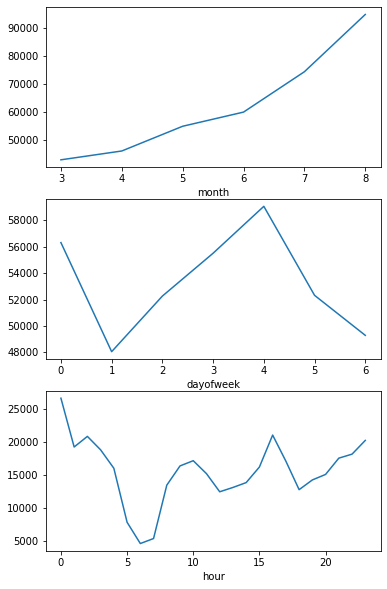

In [9]:
#Построим графики количества заказов
plt.figure(figsize=(6,10))
plt.subplot(3,1,1)
frame.groupby('month')['num_orders'].sum().plot();
plt.subplot(3,1,2)
frame.groupby('dayofweek')['num_orders'].sum().plot();
plt.subplot(3,1,3)
frame.groupby('hour')['num_orders'].sum().plot();

In [10]:
decomposed = seasonal_decompose(df) 

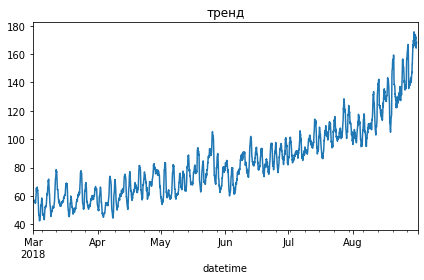

In [11]:
decomposed.trend.plot(ax=plt.gca())
plt.title('тренд')
plt.tight_layout()

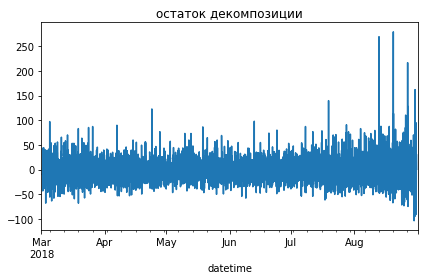

In [12]:
decomposed.resid.plot(ax=plt.gca())
plt.title('остаток декомпозиции')
plt.tight_layout()

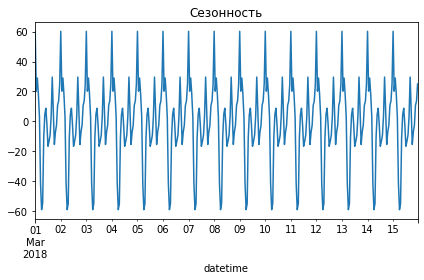

In [13]:
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.tight_layout()

### Вывод

- Временной ряд - стационарный
- Количество заказов к осени увеличивается
- Пик заказов в 20:00-24:00
- Самый нагруженный день - пятница

## Обучение

In [14]:
train, test = train_test_split(frame, test_size=0.1, shuffle=False)

In [15]:
#Проверка выборок
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [16]:
#Прогноз модели по прошлом ряду
pred_previous = np.ones(test.shape)*test.shift(fill_value = train.iloc[-1]['num_orders'])
print("RMSE:", np.sqrt(mse(test, pred_previous)))

RMSE: 46.5265759475679


In [17]:
train_features = train.drop(['num_orders'], axis =1).dropna()
train_target = train.iloc[len(train)-len(train_features):]['num_orders']
test_features = test.drop(['num_orders'], axis =1)
test_target = test['num_orders']

In [18]:
def learn(mod, params):
    if mod == CatBoostRegressor:
        model = CatBoostRegressor(logging_level='Silent')
    else:
        model = mod()
    model.fit(train_features, train_target)
    pred = model.predict(train_features)
    rmse = np.sqrt(mse(train_target, pred))
    print('RMSE base {}: {}'.format(model, '%.2f' % rmse))
    parameters = params
    tscv = TimeSeriesSplit(n_splits = 4)
    grid = GridSearchCV(model, parameters, cv = tscv, scoring = 'neg_mean_squared_error', verbose = False)
    grid.fit(train_features, train_target)
    if mod == CatBoostRegressor:
         model_tuned = mod(**grid.best_params_, logging_level='Silent').fit(train_features, train_target)
    else:
        model_tuned = mod(**grid.best_params_).fit(train_features, train_target)
    tuned_pred = model_tuned.predict(train_features)
    rmse_tuned = np.sqrt(mse(train_target, tuned_pred))
    print()
    print("RMSE tuned {}: {}".format(model, '%.2f' % rmse_tuned))
    print()
    try:
        importances = pd.DataFrame(data={
        'Attribute': train_features.columns,
        'Importance': model_tuned.feature_importances_
        })
        importances = importances.sort_values(by='Importance', ascending=False)
        plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
        plt.title('Важность признаков', size=20)
        plt.xticks(rotation='vertical')
        plt.show()
    except AttributeError:
        importances = pd.DataFrame(data={
        'Attribute': train_features.columns,
        'Importance': model_tuned.coef_
        })
        importances = importances.sort_values(by='Importance', ascending=False)
        plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
        plt.title('Важность признаков', size=20)
        plt.xticks(rotation='vertical')
        plt.show()
    return model, model_tuned, rmse, rmse_tuned

### LinearRegression

RMSE base LinearRegression(): 30.42

RMSE tuned LinearRegression(): 30.44



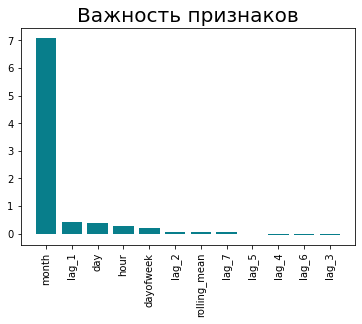

CPU times: user 810 ms, sys: 1.35 s, total: 2.16 s
Wall time: 2.18 s


In [19]:
%%time
lr_model, lr_model_tuned, lr_rmse, lr_rmse_tuned = learn(LinearRegression, {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]})

### LightGBM

RMSE base LGBMRegressor(): 14.41

RMSE tuned LGBMRegressor(): 16.70



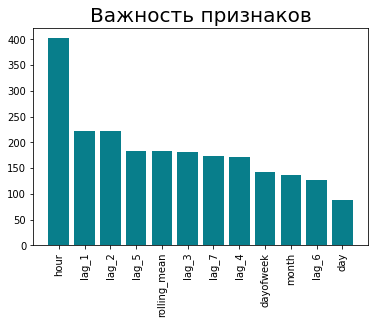

CPU times: user 18.8 s, sys: 0 ns, total: 18.8 s
Wall time: 20.3 s


In [20]:
%%time
lgb_model, lgb_model_tuned, lgb_rmse, lgb_rmse_tuned = learn(LGBMRegressor, {"n_estimators": [100, 200],
               "max_depth": [2, 4, 6]
              })

### CatBoostRegressor

RMSE base <catboost.core.CatBoostRegressor object at 0x7ff0e65d0ca0>: 12.89

RMSE tuned <catboost.core.CatBoostRegressor object at 0x7ff0e65d0ca0>: 14.57



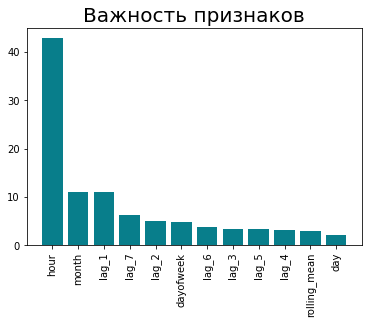

CPU times: user 1min 37s, sys: 2.71 s, total: 1min 39s
Wall time: 2min 4s


In [21]:
%%time
cat_model, cat_model_tuned, cat_rmse, cat_rmse_tuned = learn(CatBoostRegressor, {'iterations': [1000],
        'learning_rate': [0.03, 0.1],
        'depth': [6, 8],
        'l2_leaf_reg': [1, 3]                                                                                
              })

### Вывод

In [22]:
lr_rmse, lr_rmse_tuned, lgb_rmse, lgb_rmse_tuned, cat_rmse, cat_rmse_tuned

(30.42207274788726,
 30.435723057747825,
 14.412259849424178,
 16.69712755232183,
 12.89141797962129,
 14.567500005602714)

Наименьшее RMSE у базовой модели CatBoostRegressor, поэтому тестировать будем её

## Тестирование

In [23]:
#RMSE модели с гипермараметрами
fin_pred_tun = cat_model_tuned.predict(test_features)
rmse_tun = np.sqrt(mse(test_target, fin_pred_tun))
print('RMSE {}: {}'.format(cat_model_tuned, '%.2f' % rmse_tun))

RMSE <catboost.core.CatBoostRegressor object at 0x7ff0e654ed60>: 43.42


In [24]:
#RMSE базовой модели
fin_pred = cat_model.predict(test_features)
rmse = np.sqrt(mse(test_target, fin_pred))
print('RMSE {}: {}'.format(cat_model, '%.2f' % rmse))

RMSE <catboost.core.CatBoostRegressor object at 0x7ff0e65d0ca0>: 44.77


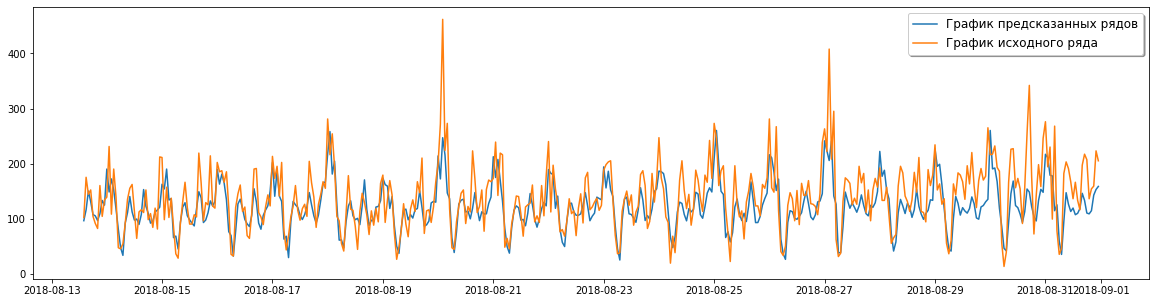

In [25]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(pd.Series(fin_pred_tun, index = test_target.index), label='График предсказанных рядов')
ax.plot(test_target, label='График исходного ряда')
legend = ax.legend(loc='upper right', shadow=True, fontsize= 12)